## 30 July 2018
-- Laurin Gray

We have our flagged points from the new selection of 8 CMDs, sorted by how many CMDs they were flagged in.  We now want to plot them on the CMDs so we can see where they are and make sure everything worked properly

The sources come from the catalog of Spitzer sources of Khan et al. (2015), matched with sources from Whitelock et al. (2013) in CasJobs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
import csv
import pathlib

In [2]:
# Read in my data from a .csv file saved locally.

# all sources
phot_data = pd.read_csv('~/Documents/Phot_data/CMDparameters26June2018_lauringray.csv')

# CMD counts
CMD_counts = pd.read_csv('/Users/lgray/Documents/Phot_data/CMD_counting_30July2018_lauringray.csv')

In [3]:
# Create all color cuts needed for plotting

phot_data['threesixMINUSeightzero'] = phot_data.k36mag.values - phot_data.k80mag.values
#
phot_data['fourfiveMINUSeightzero'] = phot_data.k45mag.values - phot_data.k80mag.values
#
phot_data['jMINUSthreesix'] = phot_data.Jmag.values - phot_data.k36mag.values
#
phot_data['hMINUSthreesix'] = phot_data.Hmag.values - phot_data.k36mag.values
phot_data['hMINUSfourfive'] = phot_data.Hmag.values - phot_data.k45mag.values

In [4]:
# Some values in the tables are +/- 9999, due to null data from combining the tables, 
# which throws off the color scaling.  We wish to exclude these values, 
# which we do by cutting to only include values in the range -500:500

filter_phot_data = phot_data[(phot_data < 500.0) & (phot_data > -500.0)]

In [5]:
# For ease in calling functions, we rename all the value arrays to exclude filter_phot_data._____.values
# Because there's so many, I'm only defining ones I'll probably need- I can add any later

# Magnitudes
threesix = filter_phot_data.k36mag.values
eightzero = filter_phot_data.k80mag.values
Hmag = filter_phot_data.Hmag.values
Kmag = filter_phot_data.Kmag.values


# Colors
threesixMINUSeightzero = filter_phot_data.threesixMINUSeightzero.values

fourfiveMINUSeightzero = filter_phot_data.fourfiveMINUSeightzero.values

jMINUSthreesix = filter_phot_data.jMINUSthreesix.values
jMINUSh = filter_phot_data.jMINUSh.values
jMINUSk = filter_phot_data.jMINUSk.values

hMINUSthreesix = filter_phot_data.hMINUSthreesix.values
hMINUSfourfive = filter_phot_data.hMINUSfourfive.values
hMINUSk = filter_phot_data.hMINUSk.values


# CMD counts
in_one = CMD_counts.in_one.values
in_two = CMD_counts.in_two.values
in_three = CMD_counts.in_three.values
in_four = CMD_counts.in_four.values
in_five = CMD_counts.in_five.values
in_six = CMD_counts.in_six.values
in_seven = CMD_counts.in_seven.values
in_eight = CMD_counts.in_eight.values

rows = phot_data.ID.values

In [6]:
def corr_rows(groups, lengths):
    """
    Some of the ID numbers are wrong (ex. there are two 2118s), which means we can't use the ID to 
    directly access the row it belongs to. As we go further down, the problem gets worse.
    This function finds the correct rows in phot_data for each ID and saves them to a list.

    Takes a list of the CMD counts you want to include in the plot (group) (and their corresponding lengths) 
    and outputs a list of the rows in phot_data which correspond to the IDs in those groups.
    
    Note that because groups must be a list, even if you are just running one column, 
    you need to define the column and length in a list first (ex. groups = [in_eight]; corr_rows(groups, lengths)).
    
    Call example:
        group = [in_eight, in_seven, in_six, in_five, in_four]
        length = [362, 141, 231, 355, 451]

        source_rows = corr_rows(group, length)
    """
    
    rows = phot_data.ID.values
    
    phot_rows = []
    
    #k = 0
    d = 0
    for j in groups:
        group_lim = lengths[d]
        k = 0
        #print(group_lim)
        for i in j:
            c = 0 # counter for phot_data rows, resets for each new element i
            # use a while loop so that it iterates until the end of the column
            while c < 30761 and k < group_lim: # to prevent reaching the end of the column and getting a nan error
                if int(i) != rows[c]: # check if i is equivalent to the ID in the current phot_data row
                    c = c+1 # if not, move to next row & go back to the top of the while loop
                else: # if i IS equivalent
                    phot_rows.append(c) # add the current row to corr_rows
                    c = 30761 # set c to stop iterating through the rest of the rows (end loop)
            k = k+1 # symbolically move onto the next element in in_ten (to stop the while loop at the end of in_ten)
        
        d = d+1
    
    return phot_rows

In [7]:
def xy_lookup(xaxis, yaxis, source_rows):
    """
    Takes the corrected row of a source in the CMD count, then uses it to look up 
    the x and y values in the phot_data table.
    source_rows should come from the output of the corr_rows function.
    
    This function is called "coord_lookup" in the 11July2018 notebook.
    
    Call example:
        x_flag, y_flag = xy_lookup(threesixMINUSeightzero, eightzero, source_rows)
    """
    
    x_vals = []
    y_vals = []
    k = 0 # row counter
    for i in source_rows:
        x_vals.append(xaxis[i])
        y_vals.append(yaxis[i])
    
    return x_vals, y_vals

In [8]:
def plot_red_layers(x_flags, y_flags, colors='consistent'):
    """
    User creates two lists containing all of the flagged x and y points that were separately saved. 
    The function then iterates through that list and scatterplots each set in a different color.
    
    This function also requires user to create a col_names list containing the names of each column included in the 
    final plot in string form.
    
    The user can choose whether to assign colors evenly based on the number of columns plotted, 
    or to keep the same colors with each column no matter how many there are.  
    To assign evenly, set colors='even'; for consistent, colors='consistent'.  The default is consistent
    
    Call example: 
        col_names = ['in_eight', 'in_seven', 'in_six', 'in_five', 'in_four']
        x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
        y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]
        plot_red_layers(x_flags, y_flags)
    """
    
    if colors is 'even':
        number = len(x_flags)  # for even color assignment
        colors = [cmap(i) for i in np.linspace(0, 1, number)]  # for even color assignment
    elif colors is 'consistent':
        cmap = plt.get_cmap('gist_rainbow')
        colors = [cmap(i) for i in np.linspace(0, 1, 5)] # for consistent color assignment
    
    k = 0
    for i in x_flags:
        plt.scatter(x_flags[k], y_flags[k], c=colors[k], label=col_names[k], s=1)
        k = k+1
    plt.legend(loc='best', fontsize=14, markerscale=4)

In [9]:
def plot_CMD(xaxis, yaxis, color='grey', y1=7.0, y2=21.5, x1=-3.0, x2=14.5, xlabel='', ylabel=''):
    """
    Plot a CMD. Default color is grey for better visibility when overplotting flagged points in color.
    
    Note that axes limits/labels are pre-defined for the 8 CMDs that were checked, but if plotting a different CMD, 
    the axis limits and labels can be manually defined.  The defaults are the biggest possible in case the user
    doesn't already know which limits to use, so they can see the full image.  
    
    Note that a pre-set axis may not automatically have the correct limits- the limits are set for a specific CMD,
    and can differ for different CMDs
    
    Call example:
        plot_CMD(xaxis, yaxis)
        OR
        plot_CMD(threesixMINUSfourfive, threesix, color='grey', y1=7.5, y2=21.5, x1=-3.0, x2=2.5, 
                xlabel='[3.6] - [4.5]', ylabel='[3.6]')
    """
    
    # pre-sets for the 8 CMDs so I can call them quickly
    if yaxis is eightzero and xaxis is threesixMINUSeightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -2.0
        x2 = 7.5
        xlabel = '[3.6] - [8.0]'
    elif yaxis is eightzero and xaxis is fourfiveMINUSeightzero:
        y1 = 8.0
        y2 = 18.0
        ylabel = '[8.0]'
        x1 = -1.5
        x2 = 6.5
        xlabel = '[4.5] - [8.0]'
    elif yaxis is Hmag and xaxis is jMINUSh:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -0.5
        x2 = 2.5
        xlabel = 'J - H'
    elif yaxis is Hmag and xaxis is hMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -1.5
        x2 = 4.0
        xlabel = 'H - [3.6]'
    elif yaxis is Hmag and xaxis is hMINUSfourfive:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'H'
        x1 = -2.5
        x2 = 5.0
        xlabel = 'H - [4.5]'
    elif yaxis is Kmag and xaxis is hMINUSk:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'K'
        x1 = -0.5
        x2 = 2.0
        xlabel = 'H - K'
    elif yaxis is Kmag and xaxis is jMINUSk:
        y1 = 11.5
        y2 = 19.0
        ylabel = 'K'
        x1 = -0.5
        x2 = 4.0
        xlabel = 'J - K'
    elif yaxis is threesix and xaxis is jMINUSthreesix:
        y1 = 11.5
        y2 = 19.0
        ylabel = '[3.6]'
        x1 = -0.5
        x2 = 6.0
        xlabel = 'J - [3.6]'
    else:
        print("That CMD is not automatically included, using defaults or manually entered values")
    
    plt.figure(figsize=(10,10))
    plt.plot(xaxis,yaxis,',', color=color)
    plt.xlim(x1, x2)
    plt.ylim(y2, y1)
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)

For reference:
- in_one: 882
- in_two: 2224
- in_three: 883
- in_four: 451
- in_five: 355
- in_six: 231
- in_seven: 141
- in_eight: 362

In [10]:
col_names = ['in_eight', 'in_seven', 'in_six', 'in_five', 'in_four']

cols = [in_eight]
col_len = [362]
eight_rows = corr_rows(cols, col_len)

cols = [in_seven]
col_len = [141]
seven_rows = corr_rows(cols, col_len)

cols = [in_six]
col_len = [231]
six_rows = corr_rows(cols, col_len)

cols = [in_five]
col_len = [355]
five_rows = corr_rows(cols, col_len)

cols = [in_four]
col_len = [451]
four_rows = corr_rows(cols, col_len)

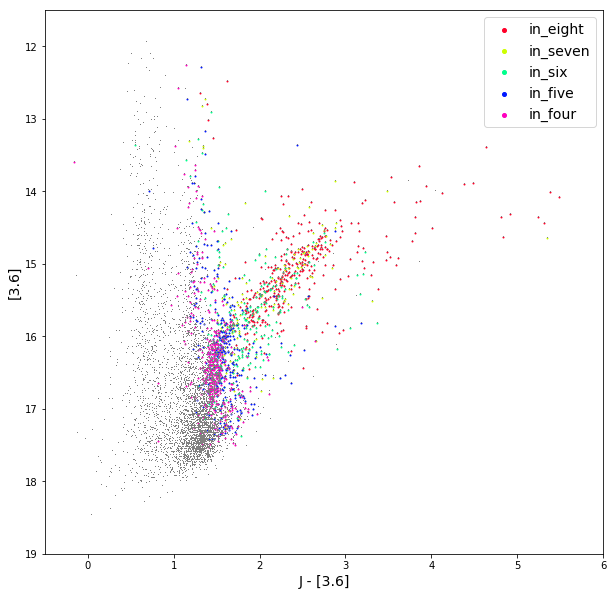

In [11]:
# [3.6] vs. J - [3.6]

xaxis = jMINUSthreesix
yaxis = threesix

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis)
plot_red_layers(x_flags, y_flags)

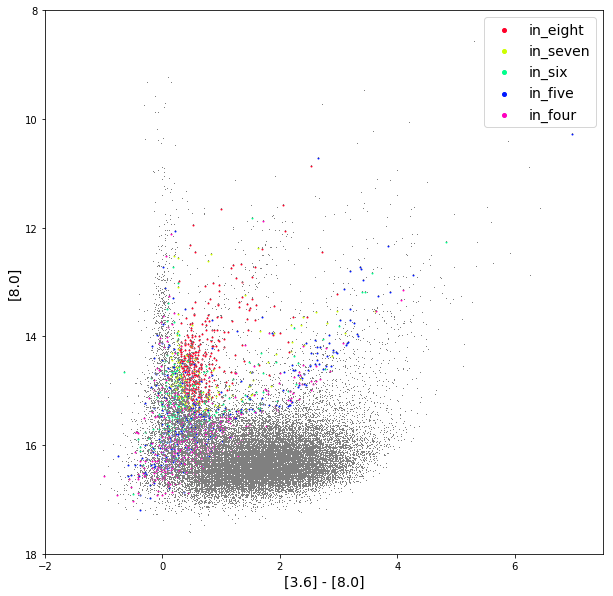

In [12]:
# [8.0] vs. [3.6] - [8.0]

xaxis = threesixMINUSeightzero
yaxis = eightzero

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')

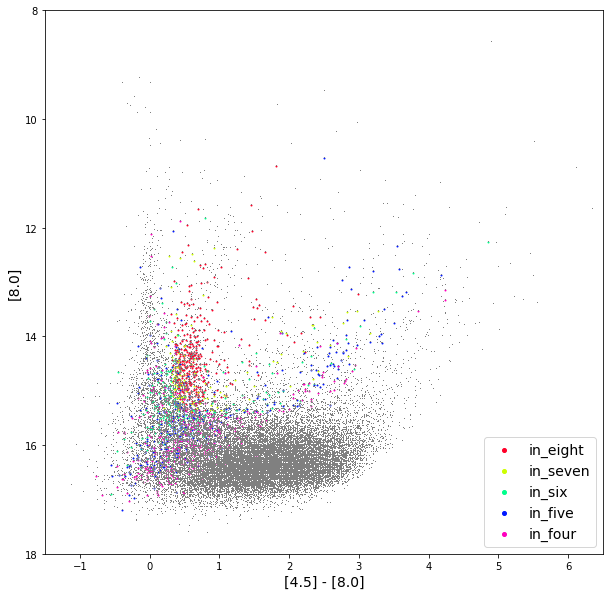

In [13]:
# [8.0] vs. [4.5] - [8.0]

xaxis = fourfiveMINUSeightzero
yaxis = eightzero

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')

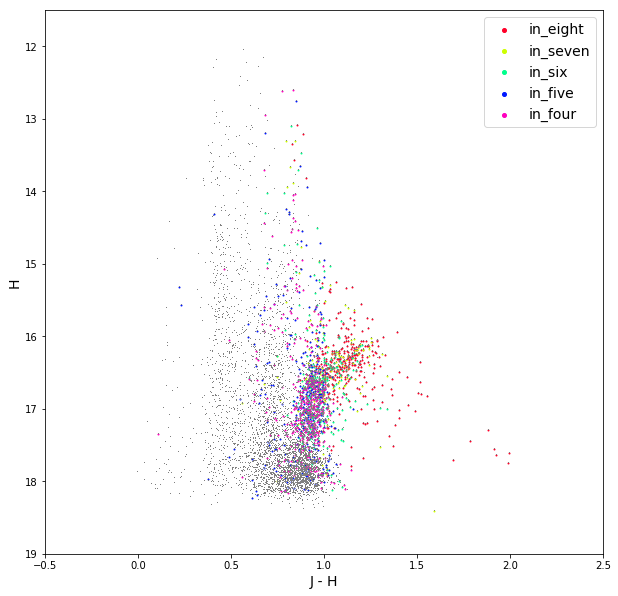

In [14]:
# H vs. J - H

xaxis = jMINUSh
yaxis = Hmag

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')
#plt.axvline(x=0.742, linewidth=0.5, color='red') # Foreground sep J-H=0.72 from Sibbons+ 2012, converted to 2MASS,
                                                    # but not shifted redder for our data

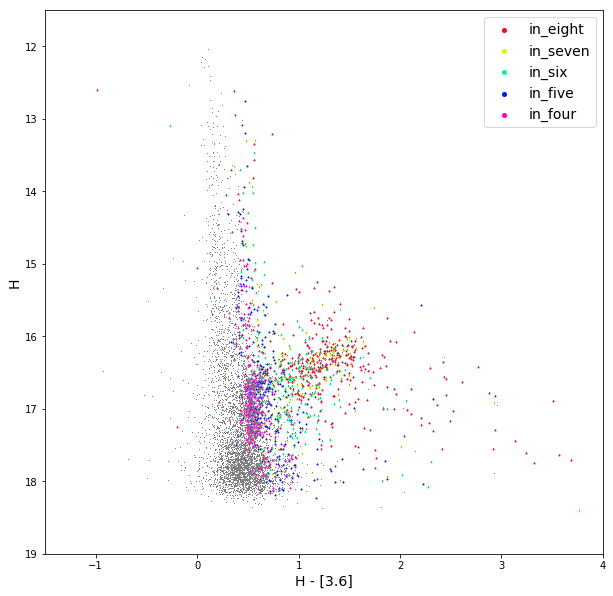

In [15]:
# H vs. H - [3.6]

xaxis = hMINUSthreesix
yaxis = Hmag

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')

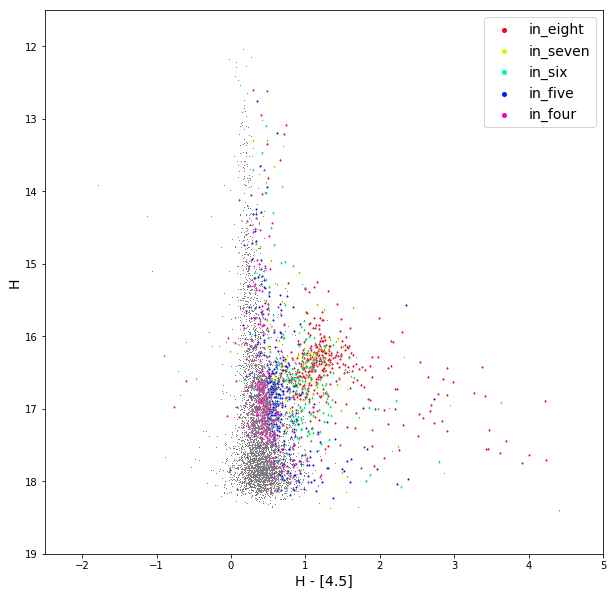

In [16]:
# H vs. H - [4.5]

xaxis = hMINUSfourfive
yaxis = Hmag

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')

0.26774393530997304


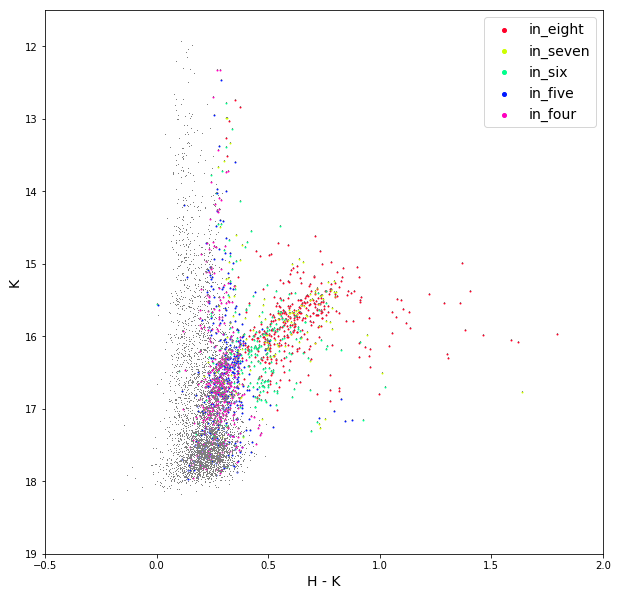

In [17]:
# K vs. H - K

xaxis = hMINUSk
yaxis = Kmag

hk_avg = np.nanmean(hMINUSk)
print(hk_avg)

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')
#plt.axvline(x=0.4, linewidth=0.5, color='red') # Potential C/O boundary from Battinelli+ 2007
#plt.axvline(x=hk_avg, linewidth=0.5, color='red')

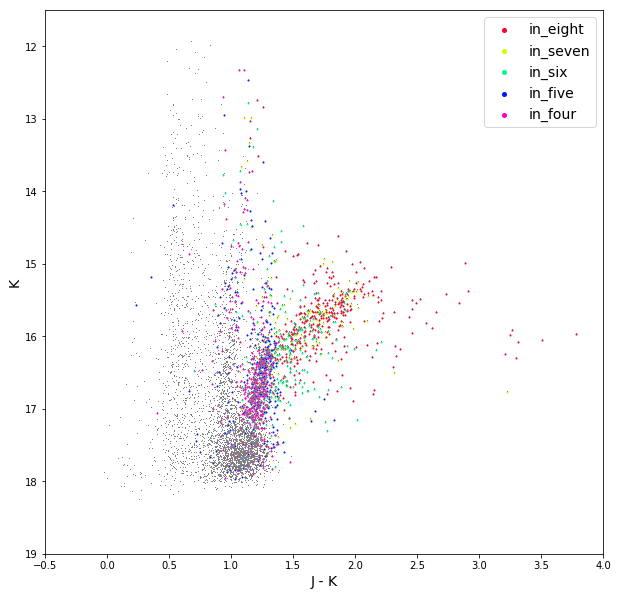

In [18]:
# K vs. J - K

xaxis = jMINUSk
yaxis = Kmag

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)

x_flags = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]

plot_CMD(xaxis, yaxis, 'grey')
plot_red_layers(x_flags, y_flags, colors='consistent')

In [19]:
# Want to plot the sequence of figures on K vs. J-K 
# i.e. all groups, then all except in_five, etc. down to just in_ten

xaxis = jMINUSk
yaxis = Kmag

x_flag_8, y_flag_8 = xy_lookup(xaxis, yaxis, eight_rows)
x_flag_7, y_flag_7 = xy_lookup(xaxis, yaxis, seven_rows)
x_flag_6, y_flag_6 = xy_lookup(xaxis, yaxis, six_rows)
x_flag_5, y_flag_5 = xy_lookup(xaxis, yaxis, five_rows)
x_flag_4, y_flag_4 = xy_lookup(xaxis, yaxis, four_rows)


x_flags_five = [x_flag_8, x_flag_7, x_flag_6, x_flag_5, x_flag_4]
y_flags_five = [y_flag_8, y_flag_7, y_flag_6, y_flag_5, y_flag_4]
col_names_five = ['in_eight', 'in_seven', 'in_six', 'in_five', 'in_four']

x_flags_four = [x_flag_8, x_flag_7, x_flag_6, x_flag_5]
y_flags_four = [y_flag_8, y_flag_7, y_flag_6, y_flag_5]
col_names_four = ['in_eight', 'in_seven', 'in_six', 'in_five']

x_flags_three = [x_flag_8, x_flag_7, x_flag_6]
y_flags_three = [y_flag_8, y_flag_7, y_flag_6]
col_names_three = ['in_eight', 'in_seven', 'in_six']

x_flags_two = [x_flag_8, x_flag_7]
y_flags_two = [y_flag_8, y_flag_7]
col_names_two = ['in_eight', 'in_seven']

x_flags_one = [x_flag_8]
y_flags_one = [y_flag_8]
col_names_one = ['in_eight']

cmap = plt.get_cmap('gist_rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, 5)] # for consistent color assignment


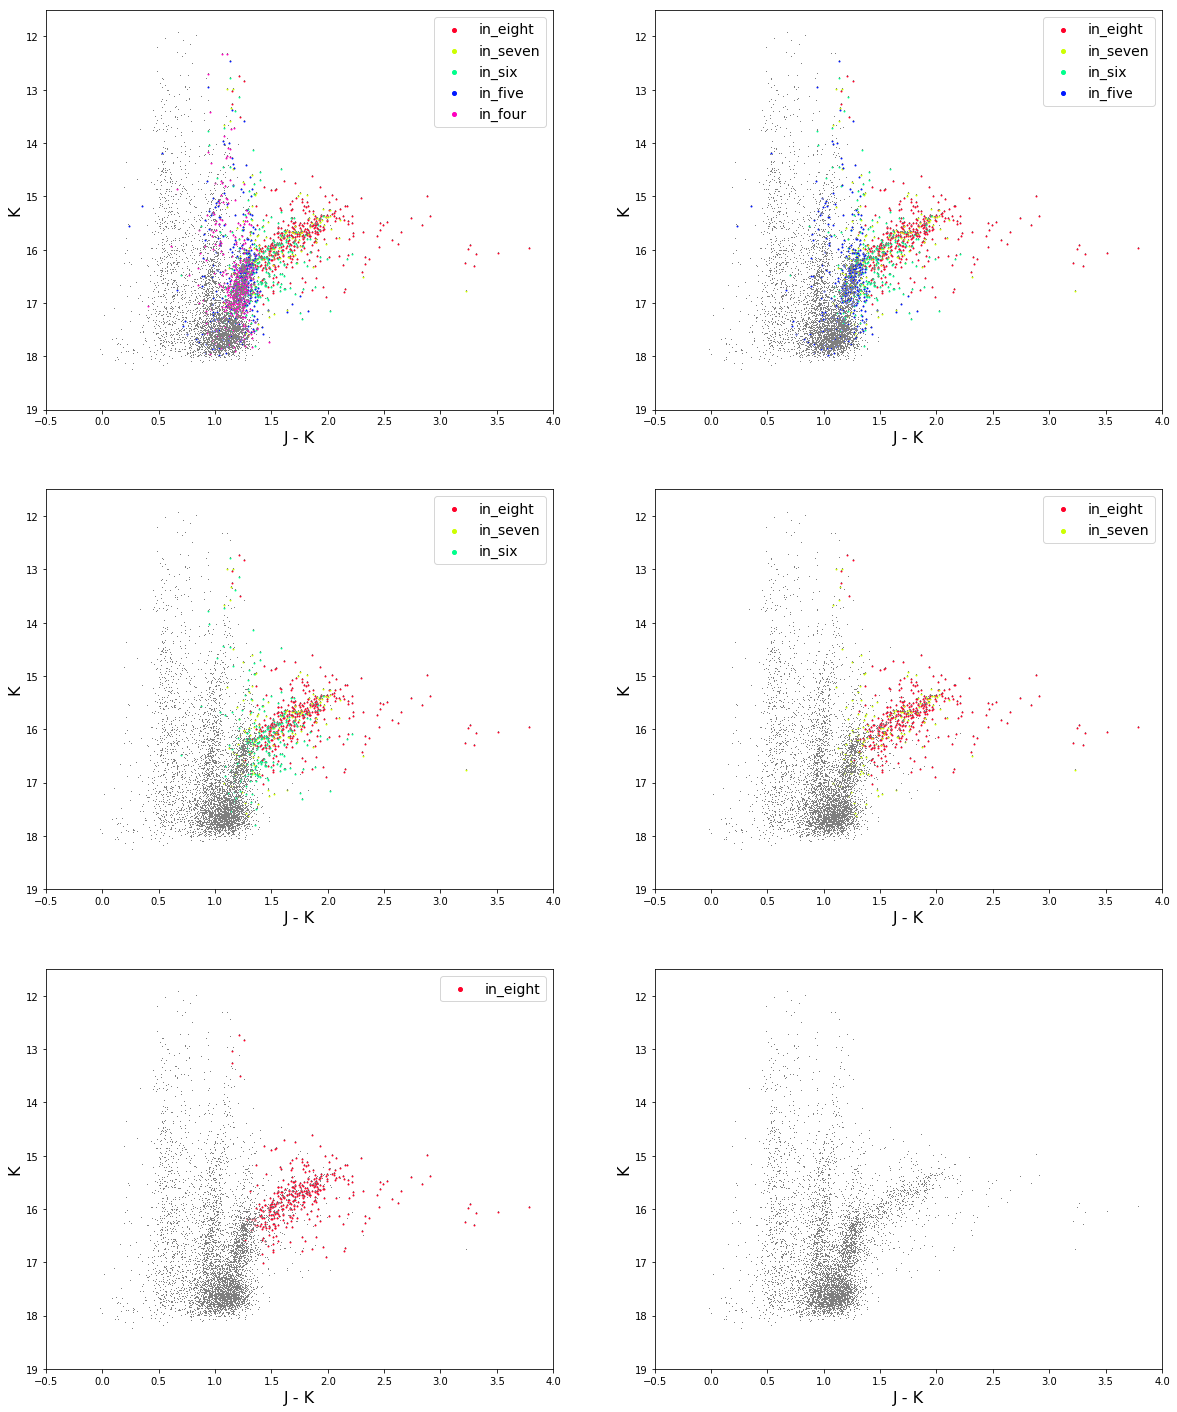

In [20]:
fig, axes = plt.subplots(3,2, figsize=(20,25))
axes = axes.flat

for n, ax in enumerate(axes):
    ax.plot(jMINUSk,Kmag,',', color='grey')
    ax.set_xlim(-0.5, 4.0)
    ax.set_ylim(19.0, 11.5)
    ax.set_xlabel('J - K', size=16)
    ax.set_ylabel('K', size=16)


k = 0
for i in x_flags_five:
    axes[0].scatter(x_flags_five[k], y_flags_five[k], c=colors[k], label=col_names_five[k], s=1)
    k = k+1
axes[0].legend(loc='best', fontsize=14.0, markerscale=4)

k = 0
for i in x_flags_four:
    axes[1].scatter(x_flags_four[k], y_flags_four[k], c=colors[k], label=col_names_four[k], s=1)
    k = k+1
axes[1].legend(loc='best', fontsize=14.0, markerscale=4)

k = 0
for i in x_flags_three:
    axes[2].scatter(x_flags_three[k], y_flags_three[k], c=colors[k], label=col_names_three[k], s=1)
    k = k+1
axes[2].legend(loc='best', fontsize=14.0, markerscale=4)

k = 0
for i in x_flags_two:
    axes[3].scatter(x_flags_two[k], y_flags_two[k], c=colors[k], label=col_names_two[k], s=1)
    k = k+1
axes[3].legend(loc='best', fontsize=14.0, markerscale=4)

k = 0
for i in x_flags_one:
    axes[4].scatter(x_flags_one[k], y_flags_one[k], c=colors[k], label=col_names_one[k], s=1)
    k = k+1
axes[4].legend(loc='best', fontsize=14.0, markerscale=4)